In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

from sklearn.feature_selection import SelectFromModel

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [4]:
train = pd.read_csv("data/data.csv")
test = pd.read_csv("data/test.csv")

# 去掉噪声
train.drop(train[(train["GrLivArea"]>4000) & (train["SalePrice"]<300000)].index, inplace=True)
train.drop(train[(train["OverallQual"]<5) & (train["SalePrice"]>200000)].index, inplace=True)

# 将测试集和训练集合并在一起
data = pd.concat([train,test], ignore_index=True)
data.drop(['Id'],axis=1, inplace=True)
print("data shape:", data.shape)

data shape: (2916, 80)


In [5]:
data["LotAreaCut"] = pd.qcut(data.LotArea,10)    # 新增一列，按照LotArea均分为10等份
data['LotFrontage']=data.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

cols = ["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    data[col].fillna(0, inplace=True)
    
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    data[col].fillna("None", inplace=True)

cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    data[col].fillna(data[col].mode()[0], inplace=True)

SalePrice    1459
dtype: int64


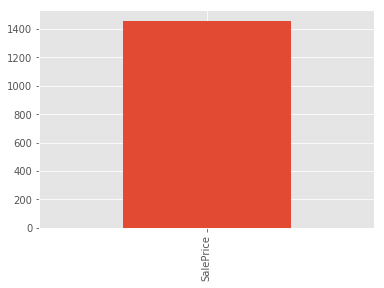

In [6]:
# 过滤数据集中各特征列含有的空值，按照空值数量降序排列
def getnullcount():
    x = data.isnull().sum()
    print(x[x>0].sort_values(ascending=False))
    x[x>0].sort_values(ascending=False).plot.bar()

getnullcount()

## 特征工程

In [9]:
NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    data[col] = data[col].astype(str)

In [10]:
# 离散化
def map_values():
    data["oMSSubClass"] = data.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    
    data["oMSZoning"] = data.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    data["oNeighborhood"] = data.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    data["oCondition1"] = data.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    data["oBldgType"] = data.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    data["oHouseStyle"] = data.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    data["oExterior1st"] = data.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    data["oMasVnrType"] = data.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    data["oExterQual"] = data.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    data["oFoundation"] = data.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    data["oBsmtQual"] = data.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    data["oBsmtExposure"] = data.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    data["oHeating"] = data.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    data["oHeatingQC"] = data.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    data["oKitchenQual"] = data.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    data["oFunctional"] = data.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    data["oFireplaceQu"] = data.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    data["oGarageType"] = data.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    data["oGarageFinish"] = data.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    data["oPavedDrive"] = data.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    data["oSaleType"] = data.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    data["oSaleCondition"] = data.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                              
    return "Done!"

map_values()

'Done!'

In [16]:
from sklearn.preprocessing import LabelEncoder
lab = LabelEncoder()
data["YearBuilt"] = lab.fit_transform(data["YearBuilt"])
data["YearRemodAdd"] = lab.fit_transform(data["YearRemodAdd"])
data["GarageYrBlt"] = lab.fit_transform(data["GarageYrBlt"])

In [20]:
def mix_features(X):
    X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
    X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]

    X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
    X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
    X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
    X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
    X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
    X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
    X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
    X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
    X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]

    X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
    X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
    X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
    X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
    X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
    X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]

    X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
    X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
    X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
    X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

    return X

data = mix_features(data)
## 删除SalePrice
data.drop(['SalePrice'], axis=1, inplace=True)
print(data.shape)


(2916, 123)


In [21]:
data_dummies = pd.get_dummies(data)
print(data_dummies.shape)

(2916, 436)


In [30]:
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
scaler = RobustScaler()
n_train = train.shape[0]
print("train length:", n_train)

X_train = data_dummies[:n_train]
X_test = data_dummies[n_train:]
y_train = train.SalePrice

X_train_scaler = scaler.fit(X_train).transform(X_train)
y_train_log = np.log(y_train)
X_test_scaler = scaler.transform(X_test)

print("缩放后的训练集特征:", X_train_scaler.shape)
print("Log后的训练集标签:", y_train_log.shape)
print("缩放后的测试集特征:", X_test_scaler.shape)

train length: 1457
缩放后的训练集特征: (1457, 436)
Log后的训练集标签: (1457,)
缩放后的测试集特征: (1459, 436)


In [31]:
model_xgb = xgb.XGBRegressor(objective='reg:linear',
                         colsample_bytree=0.7,
                         learning_rate=0.01,
                         max_depth=3,
                         n_estimators=3000,
                         subsample=0.7,
                         reg_alpha=0.0006,
                         nthread=6)

In [32]:
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [35]:
score = rmse_cv(model_xgb, X_train_scaler, y_train_log)
print("{}: {:.6f}, {:.4f}".format("XGB",score.mean(),score.std()))

XGB: 0.112421, 0.0062


In [36]:
y_trian_10000 = np.array(y_train)/10000
score = rmse_cv(model_xgb, X_train_scaler, y_trian_10000)
print("{}: {:.6f}, {:.4f}".format("XGB",score.mean(), score.std()))

XGB: 2.177249, 0.1701


In [38]:
import lightgbm as lgb

In [45]:
model_lgb = lgb.LGBMRegressor(objective='regression', 
                              colsample_bytree=0.7,
                              learning_rate=0.01,
                              max_depth=3,
                              n_estimators=3000,
                              subsample=0.7,
                              reg_alpha=0.0006,
                              nthread=20)

In [46]:
score = rmse_cv(model_lgb, X_train_scaler, y_train_log)
print("{}: {:.6f}, {:.4f}".format("XGB",score.mean(),score.std()))

XGB: 0.117413, 0.0057


In [47]:
def get_scores(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)
    model.fit(X_train, y_train)
    y_pred = model.pre

In [48]:
from sklearn.model_selection import RandomizedSearchCV

In [79]:
def rand_search(model, paras, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)
    grid = RandomizedSearchCV(model,
                              param_distributions=paras,
                              cv=5, 
                              scoring='neg_mean_squared_error',
                              n_jobs=-1)
    grid.fit(X_train, y_train)
    best_estimator = grid.best_estimator_
    print("best_estimator:", best_estimator)
    print("grid.best_score_:", grid.best_score_)
    #cvres = grid.cv_results_
    #for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    #    print(np.sqrt(-mean_score), params)


In [80]:
param_dist = {
        'objective': ['regression'],
        'n_estimators': range(2000,4000, 50),
        'max_depth': range(2,10,1),
        'subsample': [0.7, 0.8],
        'colsample_bytree':[0.6, 0.7, 0.8, 0.9],
        'learning_rate': [0.001, 0.01, 0.1],
        'reg_alpha': [0.0005,0.0006, 0.005],
}

rand_search(lgb.LGBMRegressor(thread=32), param_dist, X_train_scaler, y_train_log)

best_estimator: LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
       importance_type='split', learning_rate=0.01, max_depth=2,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=3300, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=None, reg_alpha=0.0005, reg_lambda=0.0, silent=True,
       subsample=0.7, subsample_for_bin=200000, subsample_freq=0,
       thread=32)
grid.best_score_: -0.014514544955787157


In [81]:
param_dist = {
        'objective': ['reg:linear'],
        'n_estimators': range(2000,4000, 50),
        'max_depth': range(2,10,1),
        'subsample': [0.7, 0.8],
        'colsample_bytree':[0.6, 0.7, 0.8, 0.9],
        'learning_rate': [0.001, 0.01, 0.1],
        'reg_alpha': [0.0005, 0.0006],
}

rand_search(xgb.XGBRegressor(nthread=32), param_dist, X_train_scaler, y_train_log)

best_estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=3150,
       n_jobs=1, nthread=32, objective='reg:linear', random_state=0,
       reg_alpha=0.0005, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
grid.best_score_: -0.013732771837575557


In [128]:
# 特征选择
def features_select(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)
    model.fit(X_train, y_train)
    print("特征维数:", len(model.feature_importances_))
    thresholds = [i for i in model.feature_importances_ if i >1e-5]
#     
    print("去掉权重接近0的特征维数:", len(thresholds))
    # select_split = [int(i*len(thresholds)) for i in [0.05, 0.1, 0.15,0.2,0.4,0.5, 0.85, 0.9, 0.95, 0.98]]
    # threshs = [thresholds[i] for i in select_split]
    threshs = list(set(thresholds))
    threshs.sort()
    print("去重后特征维数:", len(threshs))
    for thresh in threshs:
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
#         if select_X_train.shape[1] >= 15:
        selection_model = xgb.XGBRegressor(objective='reg:linear', 
                         colsample_bytree=0.9,
                         learning_rate=0.01,
                         max_depth=3,
                         n_estimators=3150,
                         subsample=0.8,
                         reg_alpha=0.0005,
                         nthread=32)
        selection_model.fit(select_X_train, y_train)
        # eval model
        select_X_test = selection.transform(X_test)
        print(select_X_train.shape, select_X_test.shape)
        y_pred = selection_model.predict(select_X_test)

        mse = np.sqrt(mean_squared_error(np.log(y_pred),np.log(y_test)))

        print("Thresh=%.6f, n=%d, Mse: %.6f" % (thresh, select_X_train.shape[1], mse))


In [129]:
xgb_m = xgb.XGBRegressor(objective='reg:linear', 
                         colsample_bytree=0.9,
                         learning_rate=0.01,
                         max_depth=3,
                         n_estimators=3150,
                         subsample=0.8,
                         reg_alpha=0.0005,
                         nthread=32)
features_select(xgb_m, X_train_scaler, y_train_log)                 

特征维数: 436
特征维数: 304
特征维数: 120
(1165, 304) (292, 304)
Thresh=0.000051, n=304, Mse: 0.009479
(1165, 289) (292, 289)
Thresh=0.000101, n=289, Mse: 0.009544
(1165, 271) (292, 271)
Thresh=0.000152, n=271, Mse: 0.009495
(1165, 261) (292, 261)
Thresh=0.000202, n=261, Mse: 0.009463
(1165, 242) (292, 242)
Thresh=0.000253, n=242, Mse: 0.009509
(1165, 231) (292, 231)
Thresh=0.000303, n=231, Mse: 0.009519
(1165, 226) (292, 226)
Thresh=0.000354, n=226, Mse: 0.009561
(1165, 219) (292, 219)
Thresh=0.000404, n=219, Mse: 0.009396
(1165, 212) (292, 212)
Thresh=0.000455, n=212, Mse: 0.009649
(1165, 208) (292, 208)
Thresh=0.000505, n=208, Mse: 0.009627
(1165, 202) (292, 202)
Thresh=0.000556, n=202, Mse: 0.009515
(1165, 195) (292, 195)
Thresh=0.000606, n=195, Mse: 0.009465
(1165, 186) (292, 186)
Thresh=0.000657, n=186, Mse: 0.009651
(1165, 184) (292, 184)
Thresh=0.000707, n=184, Mse: 0.009593
(1165, 177) (292, 177)
Thresh=0.000758, n=177, Mse: 0.009562
(1165, 173) (292, 173)
Thresh=0.000809, n=173, Mse: 0.0